# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10' # camera pc ip
```

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = True
ENABLE_DETECT = True
ENABLE_O3D = True

CONNECT_INDY = True
CONNECT_MOBILE = True

VISUALIZE = False
PLANNING_MULTIPROC = True

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.08, 0.32]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = 0.1 # tested one
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from utils.streaming import *
from utils.detection_util import *


from pkg.utils.shared_function import *
super_clear_shared_memory(
    names=['shared_fun.init_node.kiromobilemap.__request__',
           'shared_fun.init_node.kiromobilemap.__response__',
           'shared_fun.get_maps.kiromobilemap.__request__',
           'shared_fun.get_maps.kiromobilemap.__response__',
           'shared_fun.get_maps.kiromobilemap.0',
           'shared_fun.get_maps.kiromobilemap.1',
           'shared_fun.get_maps.kiromobilemap.2',
           'shared_fun.get_maps.kiromobilemap.3',
           'shared_fun.server.KiroMobileMap.paired',
           'shared_fun.global.error'])

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=True, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "Z"), (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(RobotType.indy7, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)


add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer, WayFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))


# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(
    gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
    dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), 
    color=(1, 0, 0, 1), display=True,
    collision=False, fixed=True)
wayframer = pscene.create_binder(
    bname="wayframer", gname="wayframer", _type=WayFramer, 
    point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"

connection command:
kmb0: True
indy1: True
[MOBILE ROBOT] bind: ('192.168.0.8', 50306)
[MOBILE ROBOT] Start UDP THREAD
goal reach: 0 -> 1 (1636027905.71)
goal reach signal edge up
Connect: Server IP (192.168.0.3)
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7-frontZ-PRQ.pkl
Loaded: indy7-frontX-PRQ.pkl
Loaded: indy7-upZ-PRQ.pkl
Loaded: indy7-downZ-PRQ.pkl


In [3]:
# from pkg.ui.ui_broker import *

# # start UI
# ui_broker = UIBroker.instance()
# ui_broker.initialize(ppline, s_builder)
# ui_broker.start_server()

# ui_broker.set_tables()

#### 0.1.2 Load environment map

In [4]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 80 
kmb.validifier = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE))<VALID_SCORE_CUT)


In [5]:
kmm.init_node(timeout=10)

In [6]:
POLE_SCALE = 2
def update_map(timeout=100, try_num=5, time_wait=0, update_poles=False):
    time.sleep(time_wait)
    maps = None
    for i in range(try_num):
        maps = kmm.get_maps(timeout=timeout)
        kmm.maps = maps
        if CONNECT_INDY and CONNECT_MOBILE:
            Q_map = crob.get_real_robot_pose()
            save_pickle(
                os.path.join(RNB_PLANNING_DIR, "data/Q_map.pkl"), 
                Q_map)
        else:
            Q_map = load_pickle(
                os.path.join(RNB_PLANNING_DIR, "data/Q_map.pkl"))
        if not CONNECT_MOBILE:
            Q_map[:6] = kmb.xyzw2joints(load_pickle(os.path.join(os.environ["RNB_PLANNING_DIR"],"data/cur_xyzw_view.pkl")))
        Tbm_map = gscene.get_tf(MOBILE_BASE, Q_map)
        kmm.set_maps(*maps, T_bm=Tbm_map, canny_ksize=10)
        
        gscene.show_pose(Q_map)    
        pt_list, costs = kmm.convert_im2scene(kmm.cost_im>0, kmm.resolution, kmm.T_bi, img_cost=kmm.cost_im)
        pt_list = np.subtract(pt_list, (0,0,kmm.resolution))
        YlOrRd = plt.get_cmap("YlOrRd")
        gcost_mesh = kmm.add_to_scene("global_cost", gscene, pt_list, kmm.resolution/2, costs, 
                                      colormap=lambda x: YlOrRd(x/2))
        
        cost_canny_res = cv2.resize(kmm.cost_canny, 
                                    dsize=(0,0), 
                                    fx=1.0/POLE_SCALE, 
                                    fy=1.0/POLE_SCALE)
        pole_res = kmm.resolution * POLE_SCALE
        pole_pt_list, costs = kmm.convert_im2scene(
            cost_canny_res>10, pole_res, kmm.T_bi, 
            img_cost=cost_canny_res)
#         lpt_list, lcosts = kmm.convert_im2scene(kmm.lcost_im>0, kmm.lresolution, kmm.T_bil, img_cost=kmm.lcost_im)
#         lpt_list = np.subtract(lpt_list, (0,0,kmm.resolution*2))
#         lcost_mesh = kmm.add_to_scene("local_cost", gscene, lpt_list, kmm.lresolution, lcosts)
#         lcost_mesh = kmm.add_to_scene("local_cost", gscene, lpt_list, kmm.lresolution, lcosts)
        if  maps is not None:
            break
    return pole_pt_list, pole_res
# Local transformation 계산 다시 확인 필요
# 한번만 가능 - ROSMASTER가 정상 연결된 상태가 아니라서?
pole_pt_list, pole_res = update_map(timeout=100)


Connect: Server IP (192.168.0.3)
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [7]:
from utils.shared_detector import SharedDetector
sd = SharedDetector()
sd.init()

#### 1.1.1 Move to bed-seek pose 

In [8]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


Connect: Server IP (192.168.0.3)


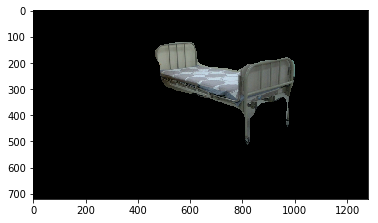

In [9]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = stream_capture_image(
            ImageType.FirstView, obj_type="bed", host=CAM_HOST,
            crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [10]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [11]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)

    bed_center = T_bo_bed[:3,3]
    bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
    COLOR_BED_COL = (0,1,0,0.3)
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    COLOR_BED_COL = (0,1,0,0.3)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.905564e-01, inlier_rmse=6.816623e-02, and correspondence_set size of 31035
Access transformation to get result.
Transformation is:
[[ 0.79136047 -0.06213929  0.60818363 -0.78730915]
 [-0.27983799 -0.9213012   0.26999036 -0.08551111]
 [ 0.5435433  -0.38385257 -0.7464703   4.37578435]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.77514968 -0.13559149  0.61705585 -1.94520273]
 [ 0.08738576 -0.94429908 -0.3172743   1.32796767]
 [ 0.62570496  0.2998

In [12]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
if True:  
        Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
        T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)
                
        with gtimer.block("ICP"):
            Tbs_f, fitness_f = icp_bed.compute_front_ICP(
                T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)
            
        
        T_bo_bed = np.matmul(T_bc, Tbs_f)
        bed_center = T_bo_bed[:3,3]
        bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
        COLOR_BED_COL = (0,1,0,0.3)
        T_bo_new = align_z(T_bo_bed)
        bed_rpy = Rot2rpy(T_bo_new[:3,:3])

        # adjust
        bed_center[2]=0
        if Rot_rpy(bed_rpy)[0,0] > 0:
            bed_rpy[2] += np.pi
        move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.074935e-01, inlier_rmse=5.094241e-02, and correspondence_set size of 15804
Access transformation to get result.
Transformation is:
[[ 0.79617254 -0.03259937  0.60419089 -0.78191677]
 [-0.23281874 -0.938173    0.25617738 -0.03930969]
 [ 0.55848436 -0.34462834 -0.75453734  4.39441648]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.0 set checker

In [13]:
wp_task, wp_hdl = add_waypoint_task(
    pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
    parent="floor_ws", color=(0, 0, 1, 1))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

#### 1.2.1  move to full view position

##### calc fule view pose

In [14]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_ref = 145
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -145
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-5, 5)
    dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/8
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, 
                    SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
#     gscene.show_pose(full_view_ext)
    ccheck.clear()
    res = ccheck(T_loal=Tbm, 
                 Q_dict=list2dict(full_view_ext, gscene.joint_names))
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break

CLOSET on LEFT


##### move to full view pose

In [15]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
real_robot_pose: [ 2.03  2.79 -0.65  0.    0.    0.    0.    0.87 -1.22 -0.   -1.57 -0.  ]


In [16]:
gscene.show_pose(VIEW_MOVED_EXT)

In [17]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

Connect: Server IP (192.168.0.3)
Send to mobile: [ 2.032  2.789 -0.319  0.948]
             -> [ 2.626  2.825 -0.331  0.944  0.   ]
Distance=0.595831801869 ([ 0.594  0.036 -0.025])
goal reach: 1 -> 0 (1636027933.43)
goal reach: 0 -> 1 (1636027943.59)
goal reach signal edge up
End up at=[ 2.648  2.834 -0.656] (0.0302 / 0.0302)
Connect: Server IP (192.168.0.3)
VIEW_MOVED_EXT: [ 2.65  2.83 -0.66  0.    0.    0.   -0.    0.87 -1.22 -0.   -1.4  -0.  ]


#### 1.2.2 redetect bed

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=9.321280e-01, inlier_rmse=5.828799e-02, and correspondence_set size of 44854
Access transformation to get result.
Transformation is:
[[-3.73572301e-02  6.49854265e-03 -9.99280866e-01  5.80024590e+00]
 [-9.97378744e-01  6.17682115e-02  3.76878132e-02  5.04308216e-01]
 [ 6.19687077e-02  9.98069365e-01  4.17401902e-03 -1.07500086e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


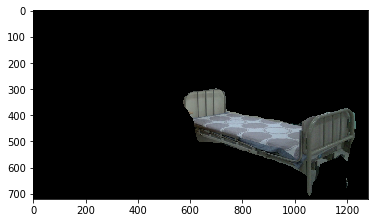

In [18]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = stream_capture_image(
        ImageType.FullView, obj_type="full_view", host=CAM_HOST,
        crob=crob)
    
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc)
    T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [19]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="top_table", host=CAM_HOST,
                                     crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.5)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=6.504911e-01, inlier_rmse=1.085920e-02, and correspondence_set size of 15563
Access transformation to get result.
Transformation is:
[[-0.99919584  0.00739473  0.0394078   5.79882875]
 [ 0.03965201  0.03644806  0.99854857  0.66358592]
 [ 0.00594765  0.99930819 -0.03671197  0.1283166 ]
 [ 0.          0.          0.          1.        ]]


In [20]:
if CONNECT_MOBILE and CONNECT_CAM:
    save_pickle("gargs.pkl".format(get_now()), 
                gscene.get_gtem_args())
else:
    filelist = sorted([fname for fname in os.listdir(os.getcwd()) if fname.startswith("gargs_")])
    gtem_args = load_pickle("gargs.pkl")      
    for garg in gtem_args:
        if garg['parent'] == None and garg['link_name']=="base_link":
            if garg["name"] in gscene.NAME_DICT:
                gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
gscene.update_markers_all() 

In [21]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

In [22]:
# # Extract triangle mesh fron rgbd image
# # If T_bc is not given, then the mesh coordinate is camera coordinate
# mesh = extract_mesh(cdp, T_bc=T_bc_new, visualize=False)

# remove_boxes = [gscene.NAME_DICT["bed_box"],
#                 gscene.NAME_DICT["closet_box"],
#                 gscene.NAME_DICT["floor_box"]
#                ]
# mesh_cut, mesh_colors = \
#     mask_boxes_mesh(mesh, remove_boxes, 
#                     VIEW_POSE_EXT, inside=False, 
#                     merge_rule=np.all, link_ref="base_link")
# gscene.create_safe(GEOTYPE.MESH, "env_mesh", link_name="base_link",
#                   dims=(1,1,1), center=(0,0,0), rpy=(0,0,0),
#                   color=(1,1,1,1), fixed=True, collision=True,
#                   vertices=mesh_cut.vertices, triangles=mesh_cut.triangles,
#                   colors=mesh_colors)


## 2. Closet cleaning

### 2.0. Prepare functions

In [23]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [24]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

### 2.1. Make closet cleaning plan

In [25]:
snode_schedule_list_leftup, scene_args_list_leftup, scene_kwargs_list_leftup, Q_CUR, test_fun, covered_all= \
    make_plan_fun(ppline, ccheck, closet_leftup, brush_face, TOOL_DIM, WP_DIMS, MOBILE_NAME,
                  robot_config, Q_CUR, "up", "Z", 1, plane_val=None,
                  planning_multiproc=PLANNING_MULTIPROC)
add_kiro_indytool_up(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), rpy=(0,0,0))
snode_schedule_list_leftfront, scene_args_list_leftfront, scene_kwargs_list_leftfront, Q_CUR, test_fun, covered_all= \
    make_plan_fun(ppline, ccheck, closet_leftup, brush_face, TOOL_DIM, WP_DIMS, MOBILE_NAME,
                  robot_config, Q_CUR, "front", "Z", 1, plane_val=None,
                  planning_multiproc=PLANNING_MULTIPROC, covered_pre=covered_all)
add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), rpy=(0,0,0))

snode_schedule_list_rightup, scene_args_list_rightup, scene_kwargs_list_rightup, Q_CUR, test_fun, covered_all = \
    make_plan_fun(ppline, ccheck, closet_rightup, brush_face, TOOL_DIM, WP_DIMS, MOBILE_NAME,
                  robot_config, Q_CUR, "up", "Z", 1, plane_val=None,
                  planning_multiproc=PLANNING_MULTIPROC)

while True:
    try:
        snode_schedule_list_down, scene_args_list_down, scene_kwargs_list_down, Q_CUR, test_fun, covered_all = \
            make_plan_fun(ppline, ccheck, closet_down, brush_face, TOOL_DIM, WP_DIMS, MOBILE_NAME,
                  robot_config, Q_CUR, "down", "Z", -1, plane_val=None,
                  planning_multiproc=PLANNING_MULTIPROC)
        break
    except:
        pass


# snode_schedule_list = snode_schedule_list_leftup
# scene_args_list = scene_args_list_leftup
# scene_kwargs_list = scene_kwargs_list_leftup

snode_schedule_list = snode_schedule_list_leftup + [ToolDir.up] + snode_schedule_list_leftfront + [ToolDir.down] + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + [ToolDir.up] + scene_args_list_leftfront + [ToolDir.down] + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + [ToolDir.up] + scene_kwargs_list_leftfront + [ToolDir.down] + scene_kwargs_list_rightup + scene_kwargs_list_down

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 32: required answers acquired from other agent =======================

Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
======================= terminated 23: required answers acquired ===============================
======================= terminated 14: required answers acquired from other agent ===============================
Goal reached
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 26: required answers acquired ===============================
Goal reached
======================= terminated 22: required answers acquired ===============================
Goal reached
======================= terminated 28: required answers acquired ===============================
Goal

Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 23: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
=

======================= terminated 0: required answers acquired ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ==============================

======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ======

======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ========

======================= terminated 16: max iteration time reached (5/5 s) ===============================
======================= terminated 22: max iteration time reached (5/5 s) ===============================
======================= terminated 30: max iteration time reached (5/5 s) ===============================
======================= terminated 25: max iteration time reached (5/5 s) ===============================
======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 35: max iteration time reached (5/5 s) ===============================
======================= terminated 23: max iteration time reached (5/5 s) ===============================
======================= terminated 11: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 31: max iter

======================= terminated 8: max iteration time reached (5/5 s) ===============================
======================= terminated 34: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 14: max iteration time reached (5/5 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 15: max iteration time reached (5/5 s) ===============================
======================= terminated 7: max iteration time reached (5/5 s) ===============================
======================= terminated 23: max iteration time reached (5/5 s) ===============================
======================= terminated 18: max iteration time reached (5/5 s) ===============================
======================= terminated 9: max iteration time reached (5/5 s) ======

======================= terminated 22: max iteration time reached (5/5 s) ===============================
======================= terminated 21: max iteration time reached (5/5 s) ===============================
======================= terminated 2: max iteration time reached (5/5 s) ===============================
======================= terminated 1: max iteration time reached (5/5 s) ===============================
======================= terminated 16: max iteration time reached (5/5 s) ===============================
======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 8: max iteration time reached (5/5 s) ===============================
======================= terminated 33: max iteration time reached (5/5 s) ===============================
======================= terminated 35: max iterati

======================= terminated 7: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 2: max iteration time reached (5/5 s) ===============================
======================= terminated 27: max iteration time reached (5/5 s) ===============================
======================= terminated 15: max iteration time reached (5/5 s) ===============================
======================= terminated 6: max iteration time reached (5/5 s) ===============================
======================= terminated 9: max iteration time reached (5/5 s) ===============================
======================= terminated 12: max iteration time reached (5/5 s) ===============================
======================= terminated 34: max iteratio

======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 11: required answers acquired ===============================
======================= terminated 9: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 13: required answers acquired ======

Goal reached
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired ===============================
Goal reached
======================= terminated 28: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 29: required answers acquired ===============================
Goal reached
======================= terminated 30: required answers acquired ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 24: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
Go

======================= terminated 27: required answers acquired from other agent ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
======================= terminated 9: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 22: required answers acquired ==============================

======================= terminated 14: max iteration time reached (5/5 s) ===============================
======================= terminated 15: max iteration time reached (5/5 s) ===============================
======================= terminated 10: max iteration time reached (5/5 s) ===============================
======================= terminated 25: max iteration time reached (5/5 s) ===============================
======================= terminated 27: max iteration time reached (5/5 s) ===============================
======================= terminated 23: max iteration time reached (5/5 s) ===============================
======================= terminated 8: max iteration time reached (5/5 s) ===============================
======================= terminated 2: max iteration time reached (5/5 s) ===============================
======================= terminated 13: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max itera

======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 26: max iteration time reached (5/5 s) ===============================
======================= terminated 16: max iteration time reached (5/5 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 10: max iteration time reached (5/5 s) ===============================
======================= terminated 8: max iteration time reached (5/5 s) ===============================
======================= terminated 0: max iteration time reached (5/5 s) ===============================
======================= terminated 29: max iteration time reached (5/5 s) ===============================
======================= terminated 34: max iteration time reached (5/5 s) ===============================
======================= terminated 15: max iteration time reached (5/5 s) ====

======================= terminated 19: max iteration time reached (5/5 s) ===============================
======================= terminated 7: max iteration time reached (5/5 s) ===============================
======================= terminated 30: max iteration time reached (5/5 s) ===============================
======================= terminated 22: max iteration time reached (5/5 s) ===============================
======================= terminated 35: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 31: max iteration time reached (5/5 s) ===============================
======================= terminated 21: max iteration time reached (5/5 s) ===============================
======================= terminated 26: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iterat

======================= terminated 32: max iteration time reached (5/5 s) ===============================
======================= terminated 12: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 11: max iteration time reached (5/5 s) ===============================
======================= terminated 28: max iteration time reached (5/5 s) ===============================
======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 19: max iteration time reached (5/5 s) ===============================
======================= terminated 30: max iteration time reached (5/5 s) ===============================
======================= terminated 9: max iteration time reached (5/5 s) ===============================
======================= terminated 0: max iterat

======================= terminated 5: required answers acquired ===============================
======================= terminated 21: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 7: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 10: required answers acquired ===============================
======================= terminated 11: required answers acquired ===============================
======================= terminated 24: required answers acquired from other agent ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
Goal 

======================= terminated 4: required answers acquired from other agent ===============================
Goal reached
======================= terminated 27: required answers acquired ===============================
Goal reached
======================= terminated 29: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 33: required answers acquired ===============================
======================= terminated 35: required answers acquired ===============================
Goal reached
======================= terminated 32: required answers acquired ===============================
======================= terminated 30: required answers acquired from other agent ===============================


======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired from other agent ============

======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 14: max iteration time reached (5/5 s) ===============================
======================= terminated 7: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 32: max iteration time reached (5/5 s) ===============================
======================= terminated 20: max iteration time reached (5/5 s) ===============================
======================= terminated 21: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 27: max iterati

======================= terminated 34: max iteration time reached (5/5 s) ===============================
======================= terminated 29: max iteration time reached (5/5 s) ===============================
======================= terminated 31: max iteration time reached (5/5 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 14: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 31: max iteration time reached (5/5 s) ===============================
======================= terminated 32: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iteration time reached (5/5 s) ===============================
======================= terminated 16: max iteration time reached (5/5 s) ===

======================= terminated 29: max iteration time reached (5/5 s) ===============================
======================= terminated 7: max iteration time reached (5/5 s) ===============================
======================= terminated 8: max iteration time reached (5/5 s) ===============================
======================= terminated 18: max iteration time reached (5/5 s) ===============================
======================= terminated 13: max iteration time reached (5/5 s) ===============================
======================= terminated 9: max iteration time reached (5/5 s) ===============================
======================= terminated 12: max iteration time reached (5/5 s) ===============================
======================= terminated 25: max iteration time reached (5/5 s) ===============================
======================= terminated 19: max iteration time reached (5/5 s) ===============================
======================= terminated 30: max iterat

======================= terminated 6: max iteration time reached (5/5 s) ===============================
======================= terminated 2: max iteration time reached (5/5 s) ===============================
======================= terminated 34: max iteration time reached (5/5 s) ===============================
======================= terminated 22: max iteration time reached (5/5 s) ===============================
======================= terminated 28: max iteration time reached (5/5 s) ===============================
======================= terminated 26: max iteration time reached (5/5 s) ===============================
======================= terminated 19: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 20: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iterat

======================= terminated 3: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
======================= terminated 6: required answers acquired ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 26: required answers acquired ===============================
Goal reached
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired ===============================
====================

Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 32: required answers acquired ===============================
Goal reached
======================= terminated 28: required answers acquired ===============================
Goal reached
======================= terminated 30: required answers acquired ===============================
Goal reached
======================= terminated 33: required answers acquired ===============================
Goal reached
======================= terminated 35: required answers acquired ===============================
Goal reached
======================= terminated 27: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
======

Goal reached
======================= terminated 24: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
======================= terminated 28: required answers acquired ===============================
Goal reached
======================= terminated 27: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 29: required answers acquired ===============================
======================= terminated 19: required answers acquired from other agent ===============================
Goal reached
======================= terminated 32: required answers acquired ===============================
Goal rea

======================= terminated 19: max iteration time reached (5/5 s) ===============================
======================= terminated 33: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 29: max iteration time reached (5/5 s) ===============================
======================= terminated 32: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 10: max iterat

======================= terminated 1: max iteration time reached (5/5 s) ===============================
======================= terminated 22: max iteration time reached (5/5 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 27: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 25: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iteration time reached (5/5 s) ===============================
======================= terminated 23: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 34: max iteration time reached (5/5 s) =====

======================= terminated 12: max iteration time reached (5/5 s) ===============================
======================= terminated 13: max iteration time reached (5/5 s) ===============================
======================= terminated 18: max iteration time reached (5/5 s) ===============================
======================= terminated 6: max iteration time reached (5/5 s) ===============================
======================= terminated 20: max iteration time reached (5/5 s) ===============================
======================= terminated 2: max iteration time reached (5/5 s) ===============================
======================= terminated 1: max iteration time reached (5/5 s) ===============================
======================= terminated 31: max iteration time reached (5/5 s) ===============================
======================= terminated 8: max iteration time reached (5/5 s) ===============================
======================= terminated 22: max iterati

======================= terminated 34: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iteration time reached (5/5 s) ===============================
======================= terminated 11: max iteration time reached (5/5 s) ===============================
======================= terminated 35: max iteration time reached (5/5 s) ===============================
======================= terminated 29: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 25: max iteration time reached (5/5 s) ===============================
======================= terminated 28: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 20: max itera

Goal reached
======================= terminated 11: required answers acquired ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 12: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 9: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired ===============================
Goal reached
Goal reached
==

Goal reached
======================= terminated 28: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 33: required answers acquired ===============================
Goal reached
======================= terminated 30: required answers acquired ===============================
Goal reached
======================= terminated 34: required answers acquired ===============================
Goal reached
======================= terminated 25: required answers acquired ===============================
Goal reached
======================= terminated 32: required answers acquired ===============================
Goal reached
======================= terminated 35: max iteration time reached (5/5 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
=========

Goal reached
======================= terminated 17: required answers acquired ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired ===============================
======================= terminated 22: required answers acquired ===============================
======================= terminated 15: required answers acquired from other agent ===================

In [26]:
# Qcur = crob.get_real_robot_pose()
# gscene.show_pose(Qcur)
# with indy:
#     indy.joint_move_make_sure(VIEW_MOVED)

### 2.2. Execute closet cleaning sequence

In [27]:
adjust_list = []
VISUALIZE = True
save_list = []
def adjust_base_on(snode, closet_gtem):
    
    for _ in range(5):
        Qref = snode.state.Q
        traj, succ = get_look_motion(mplan, ROBOT_NAME, Qref, 
                                     target_point=closet_gtem,
                                     com_link = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][-1],
                                     view_dir = [0,0,1],timeout = 1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    if ENABLE_O3D:
        icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                           Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

        save_list.append(1)
        if CONNECT_CAM:
            rdict = stream_capture_image(ImageType.FirstView, 
                                         obj_type="closet_{}".format(len(save_list)), 
                                         host=CAM_HOST, crob=crob)
        else:
            rdict, Qref = load_rdict("closet_{}".format(len(save_list)))
            gscene.show_pose(Qref)

        T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

        cdp = rdict2cdp(rdict)
        pcd_closet = cdp2pcd(cdp, T_bc)

        with gtimer.block("masking"):
            pcd_masked = mask_boxes(pcd_closet, 
                                boxes=[gscene.NAME_DICT["closet_box"]], 
                                Q=Qref, inside=True, 
                                merge_rule=np.all, link_ref="base_link")
            pcd_masked = mask_boxes(pcd_masked, 
                                boxes=[gscene.NAME_DICT["bed_box"], 
                                       gscene.NAME_DICT["bed_wall"], 
                                       gscene.NAME_DICT["floor_box"],
                                       gscene.NAME_DICT["back_wall"]], 
                                Q=Qref, inside=False, 
                                merge_rule=np.all, link_ref="base_link")

#         pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
        with gtimer.block("adding"):
            icp_closet.add_pointcloud(pcd_masked, T_bc)
        
    #     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
    #     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))

        initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
        with gtimer.block("compute_front_ICP"):
        #     T_bo_close, fitness = icp_closet.compute_ICP(initial_guess, thres=0.05, visualize=VISUALIZE)
            # front_ICP
            T_bo_close, fitness = icp_closet.compute_front_ICP(
                T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
        #     # front_cut_ICP
        #     T_bo_close, fitness = icp_closet.compute_front_cut_ICP("closet",
        #                                                            initial_guess, thres=0.05, visualize=VISUALIZE)

        # calculate transform based on obtained points
        pcd_center_prev = pcd_masked.get_center()

        T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
        T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
        T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
        T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
        T_bo_c_fix[2,3] = 0

        # get Twoff from redetection
        Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
        Tbw0 = wayframer.get_tf_handle(Qref)
        Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
        Tbw1 = np.matmul(Tbo0, Tow1)

        Qcur = np.copy(Qref)
        Qcur[:2] = Tbw1[:2,3]
        Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)
        
        Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1tar = np.matmul(Tbo1, Tow0)
        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1tar[:2,3]
        Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)

        adjust_list.append((kmb.get_qcur(), Qref, Qtar))
        try:
            Qadj = np.copy(snode.state.Q)
            Qadj[:3] = Qcur[:3]
            Qdiff = np.subtract(Qadj, snode.state.Q)
            idx_s = snode_schedule.index(snode)
            snode_cp = snode.copy(pscene)
            snode_cp.state.Q = Qadj
            ppline.search(snode_cp.state, [(2, 1)], verbose=False,
                          timeout=0.5, timeout_loop=5, 
                          multiprocess=PLANNING_MULTIPROC,
                          terminate_on_first=True, 
                          display=False, post_optimize=False, 
                          add_homing=False)

            snode_schedule_new = ppline.tplan.get_best_schedule(at_home=False)

            if len(snode_schedule_new)>0:
                snode_schedule_new += ppline.add_return_motion(
                    snode_schedule_new[-1], 
                    snode_cp.state, 
                    timeout=5, try_count=5)
            else:
                TextColors.RED.println("Update Fail")
                raise(RuntimeError("Update Fail"))
            TextColors.BLUE.println("Update SUCCESS")
            ppline.Qdiff = Qdiff
            snode_schedule[idx_s:] = snode_schedule_new
        except Exception as e:
            ppline.search_args = (snode_cp.state, [(2, 1)])
            ppline.search_kwargs = dict(verbose=False,
                          timeout=0.5, timeout_loop=5, 
                          multiprocess=PLANNING_MULTIPROC,
                          terminate_on_first=True, 
                          display=False, post_optimize=False, 
                          add_homing=True, home_pose=Qadj)
            TextColors.RED.println("Update Fail")
            print(e)
#             raise(RuntimeError("Update Fail"))
            ppline.Qdiff = None
            kmb.joint_move_make_sure(Qtar[:6], sure_count=10)


#     if CONNECT_INDY:
#         with indy: # retrieve motion
#             crob.move_joint_traj(traj_rev, one_by_one=True)
        
class SwitchState(Enum):
    NONE = 0
    BASE_MOVED = 1
    SWEEP_APPROACH = 2
    SWEEP_RETRACT = 3
    SWEEPING = 4

class ModeSwitcherKMB:
    def __init__(self, pscene, gtem_ref, push_dist=0.05):
        self.pscene = pscene
        self.crob = pscene.combined_robot
        self.push_dist = push_dist
        self.pushed_before = False
        self.gtem_ref = gtem_ref
        self.adjust = True
        ppline.Qdiff = None
        
    def switch_in(self, snode_pre, snode_new):
        
        switch_state = SwitchState.NONE
        snode_pre_cp = snode_pre.copy(pscene)
        snode_pre_cp.traj = None
#         ppline.play_schedule([snode_pre_cp, snode_new])
        
        from_state = snode_pre.state
        to_state = snode_new.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        if len(subjects) == 2: # skip base move case - update schedule
            if ppline.Qdiff is not None:
                Qdiff = ppline.Qdiff
                Qadj = np.copy(snode_pre.state.Q)
                Qadj[:2] += Qdiff[:2]
                idx_s = snode_schedule.index(snode_pre)
                ppline.updating_schedule = snode_schedule[idx_s:]
                ppline.Qadj_tmp = Qadj
                snode_pre_cp.state.Q = Qadj
                
                ppline.search(snode_pre_cp.state, [(2, 1)], verbose=False,
                              timeout=0.5, timeout_loop=5, 
                              multiprocess=PLANNING_MULTIPROC,
                              terminate_on_first=True, 
                              display=False, post_optimize=False, 
                              add_homing=False)
                
                snode_schedule_new = ppline.tplan.get_best_schedule(
                    at_home=False)
                if len(snode_schedule_new)>0:
                    snode_schedule_new += ppline.add_return_motion(
                        snode_schedule_new[-1], 
                        snode_pre_cp.state, 
                        timeout=5, try_count=5)
                else:
                    ppline.search_args = (snode_pre_cp.state, [(2, 1)])
                    ppline.search_kwargs = dict(verbose=False,
                                  timeout=0.5, timeout_loop=5, 
                                  multiprocess=PLANNING_MULTIPROC,
                                  terminate_on_first=True, 
                                  display=False, post_optimize=False, 
                                  add_homing=True, home_pose=Qadj)
                    TextColors.RED.println("Update Fail")
                    raise(RuntimeError("Update Fail"))
                TextColors.BLUE.println("Update SUCCESS")
                snode_schedule[idx_s:] = snode_schedule_new
                switch_state = SwitchState.NONE
        if len(subjects) ==0: # joint motion: quit sweep and homing - retract before motion
            if self.pushed_before and self.push_dist > 1e-6:
                switch_state = SwitchState.SWEEP_RETRACT
                from_Q = kmb.get_qcur()
                Tbm = gscene.get_tf(MOBILE_BASE, from_Q)
                Tbm2 = np.matmul(Tbm, SE3(np.identity(3), 
                                          (-self.push_dist, 0, 0)))
                Qto = np.copy(from_Q[:6])
                Qto[:2] = Tbm2[:2,3]
                print("retract")
                kmb.joint_move_make_sure(Qto, sure_count=10)
                self.pushed_before = False
        elif subjects[0] == "sweep": # sweep approach or sweeping
            i_swp = pscene.subject_name_list.index("sweep")
            if snode_pre.state.node[i_swp] == 0: # sweep approach - move forward after motoin
                print("approach")
                if not self.pushed_before:
                    switch_state = SwitchState.SWEEP_APPROACH
                else:
                    switch_state = SwitchState.NONE
            else: # sweeping
                print("sweep")
#                 indy.collision_policy = POLICY_NO_COLLISION_DETECTION
                switch_state = SwitchState.SWEEPING
        elif subjects[0] == "waypoints":
            switch_state = SwitchState.BASE_MOVED
        return switch_state

    def switch_out(self, switch_state, snode_new):
        
        kmb = self.crob.robot_dict['kmb0']
        if switch_state == SwitchState.BASE_MOVED:
            if self.adjust:
                print("adjust")
#                 raise()
                adjust_base_on(snode_new, self.gtem_ref)
#                 update_map(timeout=100, time_wait=2)
        elif switch_state == SwitchState.SWEEP_APPROACH: # move forward
            if not self.pushed_before and self.push_dist > 1e-6:
                print("push forward")
                from_Q = kmb.get_qcur()
                Tbm = gscene.get_tf(MOBILE_BASE, from_Q)
                Tbm2 = np.matmul(Tbm, SE3(np.identity(3), 
                                          (self.push_dist, 0, 0)))
                Qto = np.copy(from_Q[:6])
                Qto[:2] = Tbm2[:2,3]
                kmb.joint_move_make_sure(Qto, sure_count=10)
                self.pushed_before = True
        elif switch_state == SwitchState.SWEEPING:
            pass
#             indy.collision_policy = POLICY_KEEP_PAUSE

def ToolChange(command):
    if command==ToolDir.up:
        kmb.tool_angle = 1
        add_kiro_indytool_up(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
        brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                          point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), rpy=(0,0,0))
        print("Tool UP")
    elif command==ToolDir.down:
        kmb.tool_angle = 0
        add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
        brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                          point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), rpy=(0,0,0))
        print("Tool Down")
mode_switcher=ModeSwitcherKMB(pscene, closet_leftup)

In [28]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [29]:
swp_fin_list = []
# mode_switcher.push_dist = 0.11
mode_switcher.push_dist = 0.05
# mode_switcher.push_dist = -0.06

for i_s, (snode_schedule, sargs, skwargs) in \
        enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    if isinstance(snode_schedule, ToolDir):
        ToolChange(snode_schedule)
        continue
    print("== Schedule {} ==".format(i_s))
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
#     mode_switcher.gtem_ref = \
#         gscene.NAME_DICT[pscene.subject_dict['sweep'].geometry.parent]
    if CONNECT_INDY and CONNECT_MOBILE:
        ppline.execute_schedule(snode_schedule, one_by_one=True, 
                                mode_switcher=mode_switcher)
    else:
        ppline.play_schedule(snode_schedule)
        
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,1))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


== Schedule 0 ==
motions: 3
[INFO] Approach through: [ 4.20974248  1.59735765 -0.04016437] -> [ 4.36699437  1.73046402 -0.04016437]
Send to mobile: [ 2.648  2.834 -0.322  0.947]
             -> [ 4.21   1.597 -0.02   1.     0.   ]
Distance=2.08487531004 ([ 1.562 -1.236  0.615])
goal reach: 1 -> 0 (1636028225.35)
goal reach: 0 -> 1 (1636028233.22)
goal reach signal edge up
End up at=[ 4.226  1.537 -0.034] (0.0629 / 0.0629)
Send to mobile: [ 4.226  1.537 -0.017  1.   ]
             -> [ 4.367  1.73  -0.02   1.     0.   ]
Distance=2.13338034678 ([ 1.719 -1.103  0.615])
goal reach: 1 -> 0 (1636028235.58)
goal reach: 0 -> 1 (1636028239.55)
goal reach signal edge up
End up at=[ 4.379  1.733 -0.038] (0.0128 / 0.0128)
adjust
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult wi

======================= terminated 22: required answers acquired ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 17: required answers acquired ===============================
======================= terminated 16: required answers acquired ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 23: required answers acquired ===============================
Goal reached
==

======================= terminated 3: required answers acquired ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 4: required answers acquired ===============================
======================= terminated 14: required answers acquired from other agent ===============================
Goal reached
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired ===============================
======================= terminated 24: required answers acquired from other agent ===============================
===============

======================= terminated 27: required answers acquired from other agent ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal re

Goal reached
Goal reached
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 1: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 7: required answers acquired ===============================
======================= terminated 28: required answers acquired from other agent ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 11: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ======================

======================= terminated 15: required answers acquired ===============================
======================= terminated 18: required answers acquired ===============================
======================= terminated 16: required answers acquired ===============================
======================= terminated 0: required answers acquired from other agent ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
Update SUCCESS
binder: None
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
approach
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
push forward
Send to mobile: [ 4.449  1.729 -0.012  1.   ]
             -> [ 4.499  1.727 -0.012  1.     1.   ]
Dist

======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ======

Goal reached
Update SUCCESS
binder: None
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
approach
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
push forward
Send to mobile: [ 4.463  1.187 -0.016  1.   ]
             -> [ 4.513  1.186 -0.016  1.     0.   ]
Distance=0.0500000019948 ([ 0.05  -0.002  0.   ])
goal reach: 1 -> 0 (1636028468.08)
goal reach: 0 -> 1 (1636028480.57)
goal reach signal edge up
End up at=[ 4.517  1.187 -0.031] (0.00378 / 0.00378)
sure_count=10
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
sweep
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
retract
Send to mobile: [ 4.517  1.187 -0.015  1.   ]
             -> [ 

======================= terminated 17: max iteration time reached (5/5 s) ===============================
======================= terminated 30: max iteration time reached (5/5 s) ===============================
======================= terminated 20: max iteration time reached (5/5 s) ===============================
======================= terminated 23: max iteration time reached (5/5 s) ===============================
======================= terminated 34: max iteration time reached (5/5 s) ===============================
======================= terminated 33: max iteration time reached (5/5 s) ===============================
======================= terminated 35: max iteration time reached (5/5 s) ===============================
======================= terminated 22: max iteration time reached (5/5 s) ===============================
======================= terminated 21: max iteration time reached (5/5 s) ===============================
======================= terminated 0: max iter

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=2.092041e-01, inlier_rmse=1.568802e-02, and correspondence_set size of 11892
Access transformation to get result.
Transformation is:
[[-9.99582460e-01 -1.12032238e-02  2.66344727e-02  5.90160635e+00]
 [ 2.61926575e-02  3.78892877e-02  9.98938610e-01  7.49000001e-01]
 [-1.22004940e-02  9.99219140e-01 -3.75800251e-02  9.44990522e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 12: max iteration time reached (5/5 s) ===============================
======================= terminated 10: max iteration time reached (5/5 s) ===============================
======================= terminated 27: max iteration time reached (5/5 s) ===============================
======================= terminated 11: max iteration time reached (5/5 s) ==========================

======================= terminated 0: max iteration time reached (5/5 s) ===============================
======================= terminated 35: max iteration time reached (5/5 s) ===============================
======================= terminated 24: max iteration time reached (5/5 s) ===============================
======================= terminated 3: max iteration time reached (5/5 s) ===============================
======================= terminated 26: max iteration time reached (5/5 s) ===============================
======================= terminated 1: max iteration time reached (5/5 s) ===============================
======================= terminated 5: max iteration time reached (5/5 s) ===============================
======================= terminated 4: max iteration time reached (5/5 s) ===============================
======================= terminated 9: max iteration time reached (5/5 s) ===============================
======================= terminated 7: max iteration 

### 2.3. Clear highlight

In [30]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.remove_subject(pscene.subject_dict["sweep"])
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Bed cleaning

### 3.1 Make bed cleaning plan

#### 3.1.1 make plan

In [ ]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

BED_OFFSET = 0.05
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

snode_schedule_list, scene_args_list, scene_kwargs_list, Q_CUR, test_fun, covered_all = \
    make_plan_fun(bed_mat, Q_CUR, "front", "X", 1, EE_HEIGHT, xout_cut=True)

### 3.3 Execute bed cleaning sequence

In [ ]:
swp_fin_list = []
mode_switcher.push_dist = 0
mode_switcher.gtem_ref = closet_leftup
mode_switcher.adjust = True
dim_hf = np.divide(bed_mat.dims, 2)
for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    swp_centers = sargs[4]
    if np.min(dim_hf[0] - np.abs(swp_centers[:,0])) < np.max(TOOL_DIM):
        mode_switcher.adjust = True
    else:
        mode_switcher.adjust = False
    if CONNECT_INDY and CONNECT_MOBILE:
        ppline.execute_schedule(snode_schedule, one_by_one=True, 
                                mode_switcher=mode_switcher)
    else:
        ppline.play_schedule(snode_schedule)
        
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,1))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


### 3.4 Clear highlight

In [ ]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.remove_subject(pscene.subject_dict["sweep"])
for child in copy.copy(bed_mat.children):
    gscene.remove(gscene.NAME_DICT[child])

In [ ]:
# save_pickle("adjust_list.pkl", adjust_list)
# save_pickle("Q_all.pkl", [[snode.state.Q for snode in snode_schedule] for snode_schedule in snode_schedule_list])

## Load exp dat

In [ ]:
# adjust_list = load_pickle("adjust_list.pkl")
# gtem_args = load_pickle("gtem_args.pkl")
# Q_all = load_pickle("Q_all.pkl")

In [ ]:
# for garg in gtem_args:
#     if garg['parent'] == None and garg['link_name']=="base_link":
#         if garg["name"] in gscene.NAME_DICT:
#             gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
# gscene.update_markers_all()        

In [ ]:
# VISUALIZE = True
# adjust_base_on(Q_all[4][0], closet_leftup)

## DEV begin

## DEV end